<a href="https://colab.research.google.com/github/Akiwacky/Data_Analysis_Snapchat/blob/main/Snapchat_Dataset_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Data Analysis

###Defining the problem

The problem I want to solve is to see the ratings & reviews given by Snapchat consumers over the three years and to understand the reason why it has fluctuated.

###Planning
- What are we measuring and how? 

I will measure 10k snapchat reviews over the period 2019-2021 and check if the ratings have increased or decreased during this time. I will then investigate why.

- Where we will collect the data

I have collected this data from Kaggle - Source: https://www.kaggle.com/databar/10k-snapchat-reviews


###Introducing the Dataset 


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

file = "Snapchat_app_store_reviews.csv"
df = pd.read_csv(file, index_col=0)
df.sample(3)

,userName,rating,review,isEdited,date,title
5926,unlock my snap account,1,I WILL KEEP LEAVING ONE STAR REVIEWS UNTIL I GET MY ACCOUNT UNLOCKED. I’ve had Snapchat since it first came out and on Nov 5 it locked me out of my account. I have no 3rd party apps and I’m more than sure I haven’t been reported for abusing people on the app. It’s more than likely I need to verify my email or number through my account but I can’t do that bc I’m locked out. I have been locked out for more that 24 hours I can’t lose this account bc I have all my sons baby pictures on here because I thought they would be safer on this TRASH APP. There is no customer support email or number to help.,False,11/8/20 10:31,TRASH APP FOR LOCKING ME OUT
8013,steevie7790,3,"Snapchat is a fun app that lets you make friends and communicate with others however, snapchat can be dangerous. If downloading snapchat you should turn off your location or go on “ghost mode” this way nobody can see your location. Also make sure to not add random strangers or people you aren’t positive you know. Other than those few things snapchat is a very fun app:)",False,4/9/19 2:53,Dangers of snapchat
4295,chicken nugget person,4,I love Snapchat and I’m on it all the time but every time I get an update I don't get what every else does. Like the new colors for example every has them like they have the pastel and all the new colors and stuff but I don’t have that. I tried everything. And Snapchat updates automatically for me so it’s updated i tried deleting it and re-downloading it I powered my phone off and on again and I can’t get the new colors.,False,8/15/19 14:02,snapchat


###Analysis 

###Overview of the Data with Pandas


In [ ]:
##Calculating Summary Stats 

df['length'] = df['review'].str.len()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,9560.0,3.127615,1.397407,1.0,2.0,3.0,4.0,5.0
length,9560.0,493.795711,196.835759,140.0,355.0,452.0,580.0,1461.0


In [ ]:
df['userName'].describe(include='0').T

count       9560
unique      9557
top       #NAME?
freq           4
Name: userName, dtype: object

In [ ]:
df.loc[df['userName'] == '#NAME?']

,userName,rating,review,isEdited,date,title,length
1538,#NAME?,1,Snapchat hasn’t been working that well for me But the main issue is that it won’t let me see my friends snaps. when I send them something it says waiting to send and I’ve tried so many things like delete the app and reinstalling a couple times and turning my phone all the way off and it does nothing. I’m just really upset because Snapchat is like one of the ways that me and all my friends communicate and Snapchat not work and my friends thinking that I left them on open for almost a whole day. An that isn’t even the worse part I tried to go to support and it was like try a different internet and I’ve used a couple of different ones and I have gone place and the thing goes did that help. Yes ever much not.,False,9/1/20 6:18,Snapchat,714
4516,#NAME?,2,I would like to know as to why YALL MF’s opened over of MY 100 messages. disrespectful. I am DISTRAUGHT. I am devastated... I feel very violated. Those were MY messages. All though it’s y’all mf’s app I still think that I should have some type of privacy. To this day I will NEVER know what all those 100+ people said to me. It’s not the first time you’ve done this to me. It’s the SECOND TIME. I would like to know why you peoples did this. I am ashamed to have this app on my phone. I would like u Snapchat to know that i will be using INSTAGRAM. And i always preferred Instagram over Snapchat .,False,9/19/19 2:55,"OPENED ALL MY MESSAGES :,(",597
7484,#NAME?,4,Snapchat will freeze on me. It will then close the app and when I open the app back up It brings up a screen as it had an update everytime the app closes. This needs to get fixed because it is annoying that the app will freeze then crash on me when im trying to talk to someone. I use snapchat a lot too.,False,1/13/21 14:47,BUGS!,304
8319,#NAME?,1,"This app used to be good, Ive been on it for years now. Its a simple social media app that makes it easy to send pictures to friends, great, but the ads are ridiculous. Recently they’ve been getting a lot worse too. I cant watch anything in the discover section because after 10 seconds, a 2 minute unskipable ad pops up. It does this over and over again. I end up watching more ads than actual content. Its crazy. The aggressive ads on this app are way too out of hand.",False,6/12/20 4:11,Ads,470


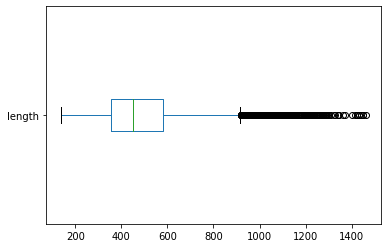

In [ ]:
## Plotting Value Distributions
df['length'].plot(kind='box', vert=False)

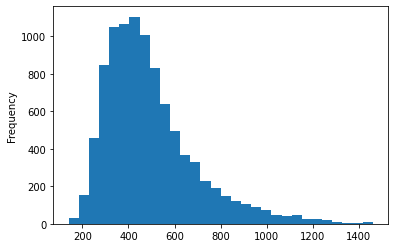

In [ ]:
df['length'].plot(kind='hist', bins=30)

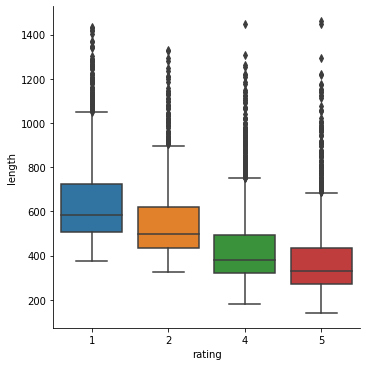

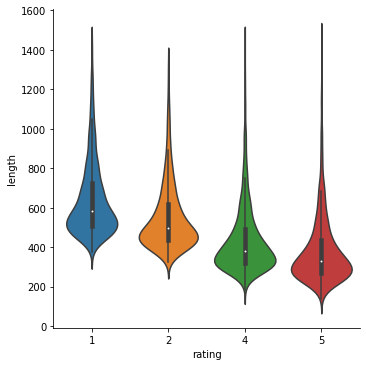

In [ ]:
where = df['rating'].isin([1,2,4,5])
sns.catplot(data=df[where], x='rating', y='length', kind='box')
sns.catplot(data=df[where], x='rating', y='length', kind='violin')

####Findings:

- Here I have measured the length of the reviews given with the Box plot & Histograms
- The majority fall within the 380-550 range with many outliers to the right. 
- It would be more ideal to compare distributions of the rating categories to see whose leaves longer reviews. 
- I would assume that those who leave a low rating will have much more to say compared to those who rated high. 
- Based on the results, we see this is true with the frequencies of the length declining as the rating increases. 

####Analysis to add
- Given the ratings, it would be good to assess what the low ratings are for and if there is a consistent pattern. 
- We can also check the average rating over time to see if it has increased or decreased.

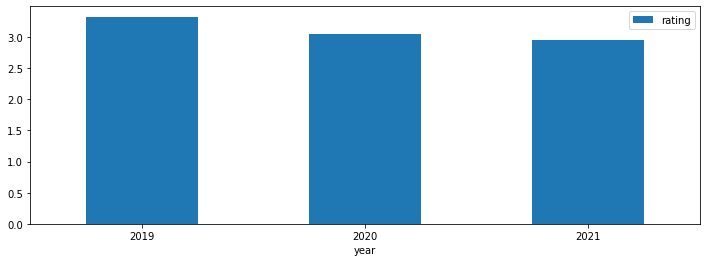

In [ ]:
## Visualizing Developments over time
df['year'] = pd.DatetimeIndex(df['date']).year
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["year"]).agg({'rating':'mean'}).plot(kind='bar', rot=0, ax=axs)


####Findings:

- The bar chart shows the ratings have decreased over time slightly. 
- I will investigate the reviews further to get an understanding of why


###Simple Text Preprocessing Pipeline

In [ ]:
import regex as re 
from tqdm.auto import tqdm
tqdm.pandas(desc="my bar!")

#Function
def tokenize(text):
  return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [ ]:
text = "would like to know as to why YALL MF’s opened over of MY 100 messages. disrespectful. I am DISTRAUGHT."
tokens = tokenize(text)
print("|".join(tokens))

would|like|to|know|as|to|why|YALL|MF|s|opened|over|of|MY|messages|disrespectful|I|am|DISTRAUGHT


In [ ]:
import nltk
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))
include_stopwords = {'also'}
exclude_stopwords = {'between'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

#Function

def remove_stop(tokens):
  return [t for t in tokens if t.lower() not in stopwords]

In [ ]:
#Function
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
  tokens = text
  for transform in pipeline:
    tokens = transform(tokens)
  return tokens 

In [ ]:
df['tokens'] = df['review'].progress_apply(prepare,pipeline=pipeline)

In [ ]:
df['num_tokens']= df['tokens'].progress_map(len)

###Word Frequency Analysis

In [ ]:
from collections import Counter

counter = Counter()
df['tokens'].map(counter.update)
print(counter.most_common(5))

[('app', 11021), ('snapchat', 10933), ('like', 5276), ('snap', 4335), ('people', 3951)]


In [ ]:
#Function

def count_words(df, column='tokens', preprocess=None, min_freq=2):

  #process tokens and update counter
  def update(doc):
    tokens = doc if preprocess is None else preprocess(doc)
    counter.update(tokens)
  
  #create counter and run through all data
  counter = Counter()
  df[column].map(update)

  #transform counter into a Dataframe 
  freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
  freq_df = freq_df.query('freq >= @min_freq')
  freq_df.index.name = 'token'

  return freq_df.sort_values('freq', ascending=False)

In [ ]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
app,11021
snapchat,10933
like,5276
snap,4335
people,3951


[Text(0, 0.5, 'Token'), Text(0.5, 0, 'Frequency'), Text(0.5, 1.0, 'Top Words')]

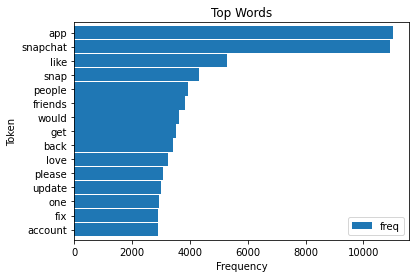

In [ ]:
#Creating a frequency Diagram 

ax = freq_df.head(15).plot(kind='barh', width=0.95)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

(-0.5, 399.5, 199.5, -0.5)

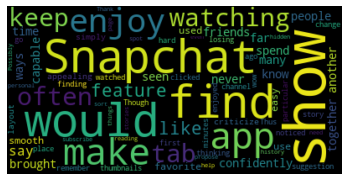

In [ ]:
#Creating Word Clouds
from wordcloud import WordCloud

text = df.query("year==2019")['review'].values[0]

wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

In [ ]:
#Function
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

  wc = WordCloud(width=800, height=400, background_color="black", 
                 colormap="Paired", max_font_size=150, max_words=max_words)

  #convert Dataframe into dict
  if type(word_freq) == pd.Series:
    counter = Counter(word_freq.fillna(0).to_dict())
  else:
    counter = word_freq

  #filter stop words in frequency counter
  if stopwords is not None:
    counter = {token:freq for (token,freq) in counter.items() 
    if token not in stopwords}
  
  wc.generate_from_frequencies(counter)

  plt.title(title)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')


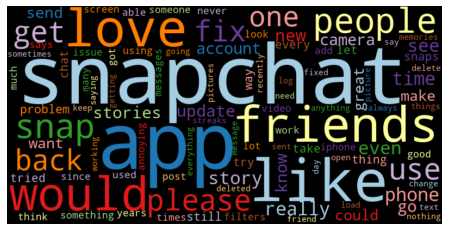

In [ ]:
freq_2019_df = count_words(df[df['year']==2019])
plt.figure(figsize=(12,4))
wordcloud(freq_2019_df['freq'], max_words=100)


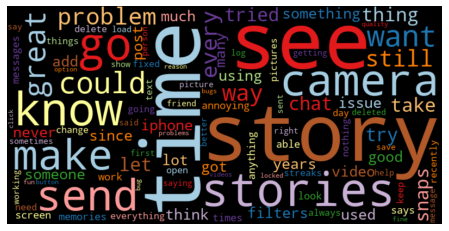

In [ ]:
plt.figure(figsize=(12,4))
wordcloud(freq_2019_df['freq'], max_words=100, stopwords=freq_df.head(20).index)


In [ ]:
#Ranking with TF-IDF
import numpy as np

def compute_idf(df, column='tokens', preprocess=None, min_df=2):
  
    def update(doc):
      tokens = doc if preprocess is None else preprocess(doc)
      counter.update(set(tokens))

    # count tokens 
    counter = Counter()
    df[column].map(update)

    # create DataFrame and compute idf 
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [ ]:
idf_df = compute_idf(df)
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

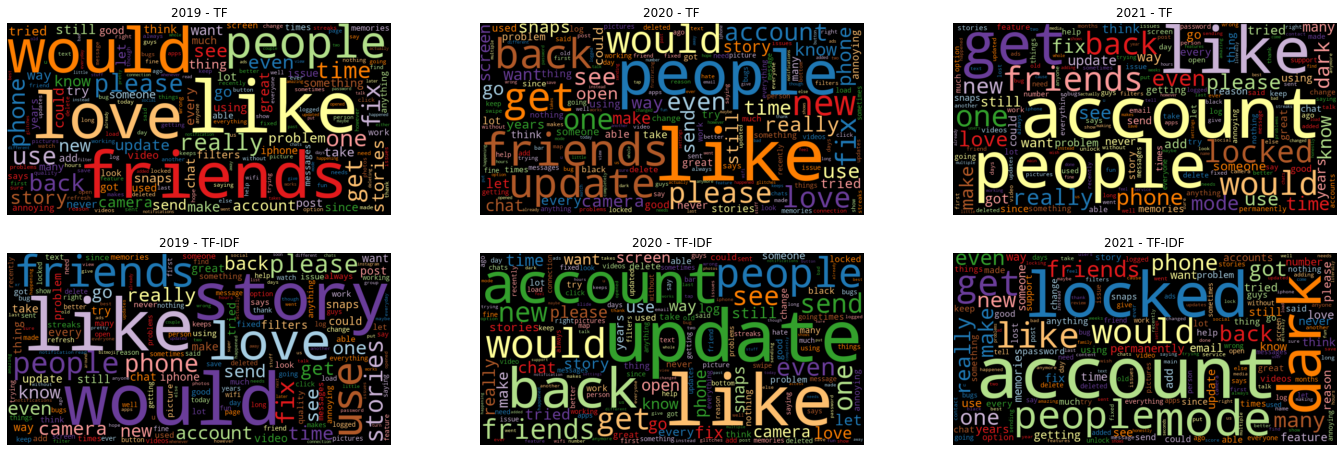

In [ ]:
freq_2019 = count_words(df[df['year'] == 2019])
freq_2020 = count_words(df[df['year'] == 2020])
freq_2021 = count_words(df[df['year'] == 2021])

freq_2019['tfidf'] = freq_2019['freq'] * idf_df['idf']
freq_2020['tfidf'] = freq_2020['freq'] * idf_df['idf']
freq_2021['tfidf'] = freq_2021['freq'] * idf_df['idf']

plt.figure(figsize=(24,12)) ###

#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
plt.subplot(3,3,1)###
wordcloud(freq_2019['freq'], title='2019 - TF', 
          stopwords=['snapchat', 'app', 'snap'])
plt.subplot(3,3,2)###
wordcloud(freq_2020['freq'], title='2020 - TF', 
          stopwords=['snapchat', 'app', 'snap'])
plt.subplot(3,3,3)###
wordcloud(freq_2021['freq'], title='2021 - TF', 
          stopwords=['snapchat', 'app', 'snap'])
plt.subplot(3,3,4)###
wordcloud(freq_2019['tfidf'], title='2019 - TF-IDF', 
          stopwords=['snapchat', 'app', 'snap'])
plt.subplot(3,3,5)###
wordcloud(freq_2020['tfidf'], title='2020 - TF-IDF', 
          stopwords=['snapchat', 'app', 'snap'])
plt.subplot(3,3,6)###
wordcloud(freq_2021['tfidf'], title='2021 - TF-IDF', 
          stopwords=['snapchat', 'app', 'snap'])

Findings:
- By separating the reviews by year and using a word cloud to highlight the words frequently used* we can create a conclusion as to why the ratings had declined over the three-year period. 

- 2019 main words show a positive sentiment while 2020 & 2021 appear slightly otherwise. 

- It appears that a potential update in 2020 was not well received from consumers and in 2021 some had an issue with their account. 

- A quick Google check pointed in the direction of an article published in Aug 2020 which confirmed my assumptions. Source: https://www.distractify.com/p/how-to-get-rid-of-new-snapchat-update

- I could not find a clear reason as to why the accounts have been locked but I noticed via the google trends that searches for  Snapchat locked & Snapchat accounts had been increasing compared to 2020. To delve further into finding the reason we can use an algorithm called keyword in content. 

- Keyword in context (KWIC) produces a list of text fragments from the left and right sides of the keyword we are looking for. This will allows us to gather more context as to why this particular word keeps popping up.

*TF IDF stands for term frequency-inverse document frequency. The process here was to use a weighting factor that measures the unusualness of a term in a dataset. In other words, I have given less importance to the more common words in order to really see the differences of terms used in the review across the three years to highlight the differences.

In [ ]:
## Finding a Keyword-in-Context

# https://pypi.org/project/textacy/
!pip install textacy
import textacy
from textacy.extract.kwic import keyword_in_context
import random

In [ ]:

def kwic(doc_series, keyword, window=75, print_samples=5):

      def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True, 
                              window_width=window))

      kwic_list = []
      doc_series.progress_map(add_kwic)

      if print_samples is None or print_samples==0:
          return kwic_list
      else:
          k = min(print_samples, len(kwic_list))
          print(f"{k} random samples out of {len(kwic_list)} " + \
                f"contexts for '{keyword}':")
          for sample in random.sample(list(kwic_list), k):
              print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                    sample[1]+'  '+\
                    re.sub(r'[\n\t]', ' ', sample[2]))

In [ ]:
kwic(df[df['year'] == 2021]['review'], 'account', print_samples=10)


10 random samples out of 832 contexts for 'account':
I had a snapchat   account   for about 5 months and all of a sudden it’s started logging me out and whe
but can't seem to reach you I really need that account is also my business   account   is how I communicate and interact with other people. And Have way to many 
’t do anything. Then the support team just says Snapchat can’t unlock your   account   but yet your telling me they can lock it ?? Snapchat your app needs to be 
I’ve made probably 6 or 7 different   account  s over the past 2 years because they keep on being deleted. Or Snapchat mak
at for a long time and I just got to say I am disappointed!! I have had my   account   for almost 4 years and I had so much memories, I don’t know what’s going o
e’s why your account may have been locked”. Not to mention, both times, my   account   was permanently locked without any warning at all.
 like 5 times it locked me out and then permanently, and i’ve made two new   account  s and the

#### Findings 

- From the findings, it appears many have experienced their account being locked due to a violation of Snapchat terms & conditions - particularly with a breach in using "third-party apps". 

- We also see many unsure how to contact Snapchat to get a reason of why their account was locked or a resolution. 

### Conclusion 

- So, to conclude we notice that Snapchat ratings and reviews have decreased over time largely to a new update disliked by consumers and changes to the terms and conditions of the app.
- To add to this analysis we could also check to see if at the time of the new update, did it have an impact on the share price.